In [ ]:
%pip install huggingface_hub[hf_xet]
%pip install hf_xet
%pip install huggingface_hub
%pip install torch torchvision torchaudio
%pip install transformers diffusers safetensors accelerate
%pip install matplotlib

from huggingface_hub import snapshot_download, login
import os

token=""
#Your HF token here.
login(token=token)

In [1]:
import torch, math
from diffusers import DiffusionPipeline
import torch.nn.functional as F
from functools import partial

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16

pipe = DiffusionPipeline.from_pretrained("cagliostrolab/animagine-xl-4.0", torch_dtype=DTYPE, resume_download=True).to(DEVICE)
#We use this fine-tune because it works decently well with the saliency maps.

Keyword arguments {'resume_download': True} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def encode(text):
    tok = pipe.tokenizer(text, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt").to(DEVICE)

    t1, _ = pipe.text_encoder(tok.input_ids, return_dict=False)
    p2, t2 = pipe.text_encoder_2(tok.input_ids, return_dict=False)
    #For whatever reason, in SDXL, text_encoder returns the tokens followed by the pooled token, while text_encoder_2 returns them in the opposite order.

    seq_embeds = torch.cat([t1, t2], dim=-1).to(DTYPE)
    pooled_embed = p2.to(DTYPE)
    return seq_embeds, pooled_embed

def get_embedding_triplets(pipe, uncolored_prompt, colored_prompt):
    seq_uncond, pool_uncond = encode("")
    seq_main, pool_main = encode(uncolored_prompt)
    seq_color, pool_color = encode(colored_prompt)

    EMB_TRIPLET = torch.cat([seq_uncond, seq_main, seq_color], dim=0)
    POOLED_TRIPLET = torch.cat([pool_uncond, pool_main, pool_color], dim=0)

    proj_dim = pipe.text_encoder_2.config.projection_dim
    time_ids = pipe._get_add_time_ids(
        original_size=(1024, 1024),
        crops_coords_top_left=(0, 0),
        target_size=(1024, 1024),
        dtype=DTYPE,
        text_encoder_projection_dim=proj_dim
    ).to(DEVICE)
    TIME_IDS_TRIPLET = time_ids.repeat(3, 1)

    return EMB_TRIPLET, POOLED_TRIPLET, TIME_IDS_TRIPLET

CFG_SCALE = 7.0

In [4]:
def color_tensor(red, green, blue, width, height):
    #Returns a tensor of shape (1, 3, width, height) which is just the solid RGB color, scaled so that the values are in (-1, 1).
    r_plane = torch.full((width, height), 2*red/255.0 - 1, dtype=torch.float32)
    g_plane = torch.full((width, height), 2*green/255.0 - 1, dtype=torch.float32)
    b_plane = torch.full((width, height), 2*blue/255.0 - 1, dtype=torch.float32)

    full_tensor = torch.stack([r_plane, g_plane, b_plane], dim=0)
    return full_tensor.unsqueeze(0).to(DEVICE)

In [5]:
def mean_from_eps(eps_pred, sample, timestep, scheduler):
    #Computes the mean of the Gaussian that gets sampled from at the end of each step, given the predicted noise eps_pred.
    #The standard formula, which you can see below (A_t * sample + B_t * eps_pred).
    #Unfortunately, the scheduler doesn't save more than just alphas_cumprod, so we have to compute a bit from scratch.
    a_bar = torch.as_tensor(scheduler.alphas_cumprod, device=DEVICE, dtype=DTYPE)

    matches = (scheduler.timesteps == timestep).nonzero(as_tuple=True)[0]
    idx = matches[0].item()
    t_prev = scheduler.timesteps[idx + 1] if idx + 1 < len(scheduler.timesteps) else 0
    t_prev = int(t_prev)
    
    a_t = a_bar[timestep]
    a_tm1 = a_bar[t_prev]

    A_t = torch.sqrt(a_tm1) / torch.sqrt(a_t)
    B_t = torch.sqrt(1.0 - a_tm1) - A_t * torch.sqrt(1.0 - a_t)

    return A_t * sample + B_t * eps_pred

In [6]:
def eps_from_mean(mean, sample, timestep, scheduler):
    #The inverse of the above function, computing the predicted noise from the final Gaussian mean.
    #Yeah, I suppose I'm doing the exact same computations twice, I suppose I could optimize this... oh well.
    a_bar = torch.as_tensor(scheduler.alphas_cumprod, device=DEVICE, dtype=DTYPE)

    matches = (scheduler.timesteps == timestep).nonzero(as_tuple=True)[0]
    idx     = matches[0].item()
    t_prev = scheduler.timesteps[idx + 1] if idx + 1 < len(scheduler.timesteps) else 0
    t_prev = int(t_prev)

    a_t    = a_bar[timestep]
    a_tm1    = a_bar[t_prev]

    A_t = torch.sqrt(a_tm1) / torch.sqrt(a_t)
    B_t = torch.sqrt(1.0 - a_tm1) - A_t * torch.sqrt(1.0 - a_t)

    if B_t == 0:
        return torch.zeros_like(mean)
        #It is possible that B_t=0; say, if we're repeating a timestep. It shouldn't happen frequently, though, so it doesn't matter too much.

    return (mean - A_t * sample) / B_t

In [7]:
@torch.no_grad()
def modify_dist_eps(
    eps_pred: torch.Tensor, #The noise as predicted by the U-net.
    var_t: torch.Tensor, #The variance in the noise Gaussians that we sample from, as computed in var_from_alphas in the next cell.
    sample: torch.Tensor, #The latent.
    timestep,
    scheduler,
    color_mean: torch.Tensor, #The latent representing what a solid block of the desired color looks like in latent space.
    saliency_mask: torch.Tensor, #Determines which cells in the latent will actually be modified.
    color_var: float #A lower color_var corresponds to a stronger weight given to just being the solid color.
):
    #The crux function which actually modifies the latent distribution to push it towards the desired color.
    var_t = var_t.to(DEVICE)
    color_mean = color_mean.to(DEVICE).float()
    color_var = torch.tensor(color_var, device=DEVICE)
    
    mu_orig = mean_from_eps(eps_pred, sample, timestep, scheduler)

    color_var_tensor = torch.full_like(var_t.expand_as(mu_orig), color_var)

    mu_new = (mu_orig * color_var_tensor + color_mean * var_t) / (color_var_tensor + var_t)
    #This is essentially a product-of-experts of the initial Gaussian with mean mu_orig and variance var_t and the "solid color Gaussian" with mean color_mean and variance color_var.
    eps_new = eps_from_mean(mu_new, sample, timestep, scheduler)
    
    eps_new_masked = saliency_mask * eps_new + (1 - saliency_mask) * eps_pred

    return eps_new_masked.to(dtype=DTYPE)

In [8]:
def var_from_alphas(scheduler, timestep):
    #(Re-)computes, at a given timestep, the variance of the Gaussian that we sample from at each step.
    #The standard formula.
    a_bar = torch.as_tensor(scheduler.alphas_cumprod, device=DEVICE, dtype=DTYPE)

    matches = (scheduler.timesteps == timestep).nonzero(as_tuple=True)[0]
    idx = matches[0].item()
    t_prev = scheduler.timesteps[idx + 1] if idx + 1 < len(scheduler.timesteps) else 0
    t_prev = int(t_prev)

    a_t = a_bar[timestep]
    a_tm1 = a_bar[t_prev]

    b_t = 1 - a_t
    b_tm1 = 1 - a_tm1

    return (b_tm1 / b_t) * (1 - a_t / a_tm1)

In [9]:
def xattn_hook(module, args, kwargs, output, *, token_indices=None, final_saliency=None):
    #Modifies the final_saliency tensor using DAAM.
    saliency_to_add = torch.zeros_like(final_saliency)

    hidden_states = args[0]
    encoder_hidden_states = kwargs["encoder_hidden_states"]

    q = module.to_q(hidden_states)[1]
    k = module.to_k(encoder_hidden_states)[1]
    h = module.heads

    latent_in = hidden_states[1]
    for token_index in token_indices:
        text_latent_k = encoder_hidden_states[:, token_index][1]

        d = q.shape[-1] // h #Head dimension.
        scale = 1 / math.sqrt(d)
        N = hidden_states.shape[-2] #Number of image latent tokens.

        q_h = q.view(N, h, d).transpose(0, 1)
        k_h = k[token_index].view(h, d)

        logits = torch.einsum("hnd,hd->hn", q_h * scale, k_h)
        weights = logits.softmax(dim=-1)

        #Yes, these are all exactly the computations that're already done in the usual forward pass, so you could say it's inefficient.
        #But the module doesn't seem to save the results of those computations, so it's least painful to just redo them. They don't add much overhead.

        saliency_flat = weights.mean(0)
        H = W = int(math.isqrt(N))
        #Well, the working assumption is a square image. It's a little hacky, but...
        saliency_map  = saliency_flat.view(H, W)

        sal_up = F.interpolate(saliency_map.unsqueeze(0).unsqueeze(0), size=(1024 // 8, 1024 // 8), mode="nearest")[0, 0]
        saliency_to_add += sal_up

    saliency_to_add /= len(token_indices)
    #Normalize so that the saliency cutoff doesn't depend on the number of tokens in the substring.
    final_saliency += saliency_to_add

In [10]:
import bisect
import re

def extract_tokens_containing_subprompt(tokenizer, prompt, subprompt):
    #Returns a list of token indices that correspond to the minimal token set of prompt that contains the first instance of subprompt.
    #Seems like it should be easy, but actually a bit annoying with how SDXL's tokenizer works.

    #First we normalize prompt and subprompt by enocding and then decoding them with the tokenizer.
    ids = tokenizer(prompt, add_special_tokens=False).input_ids
    n = len(ids)
    toks = tokenizer.convert_ids_to_tokens(ids)
    canon = tokenizer.convert_tokens_to_string(toks) #Normalized prompt.

    sub_ids = tokenizer(subprompt, add_special_tokens=False).input_ids
    sub_canon = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(sub_ids)) #Normalized subprompt.

    #Now find the normalized subprompt in the normalized prompt.
    start = canon.find(sub_canon)
    if start == -1:
        raise IndexError("colored_prompt must be a substring of prompt")
    end = start + len(sub_canon)

    #Now we create the list 'pieces', which is almost the same as 'toks' but with only characters that appear in the converted string.
    pieces = []
    recon = ""
    for k in range(n):
        new_recon = tokenizer.convert_tokens_to_string(toks[:k+1])
        piece = new_recon[len(recon):]
        pieces.append(piece)
        recon = new_recon
    
    #With 'pieces', we can now determine the exact indices of the token cutoffs inside the original prompt.
    token_index_cutoffs = [0]
    for p in pieces:
        token_index_cutoffs.append(token_index_cutoffs[-1] + len(p))

    #Now that we have the token index cutoffs in prompt as well as the start and end index of subprompt in prompt, it's straightforward to get the list of tokens containing the subprompt.
    left = max(0, bisect.bisect_right(token_index_cutoffs, start) - 1)
    right = bisect.bisect_left(token_index_cutoffs, end)
    return list(range(left+1, right+1))
    #We add 1 to account for the BoS token.

In [11]:
import matplotlib.pyplot as plt
import cv2

def generate_colored_image(
    pipe, #The diffusion model.
    prompt,
    colored_prompt, #The substring of prompt that should be assigned the color. colored_prompt should be a substring of prompt, or an error will be raised.
    color, #The desired color, as a list of RGB values, i.e. [R, G, B]
    negative_prompt,
    color_var: float, #Essentially an inverse weighting. Larger values correspond to weaker color biasing, and vice versa.
    use_alt_saliency: bool, #If True, uses both DAAM and a prompt differential to create the saliency map. If False, just uses DAAM.
    saliency_cutoff: float, #The cutoff to turn a saliency map (floats) into a proper saliency mask (0s/1s).
    max_timestep: int = 700, #An upper bound on timesteps that will be color-modified.
    min_timestep: int = 0 #A lower bound on timesteps that will be color-modified.
):

    token_indices = extract_tokens_containing_subprompt(pipe.tokenizer, prompt, colored_prompt)
    colored_prompt_idx = prompt.find(colored_prompt)
    altered_prompt = prompt[:colored_prompt_idx] + "pink " + prompt[:colored_prompt_idx]
    
    EMB_TRIPLET, POOLED_TRIPLET, TIME_IDS_TRIPLET = get_embedding_triplets(pipe, prompt, altered_prompt)
    #Because I'm being lazy and this just a demo, we'll always pass altered_prompt through the U-Net, even if use_alt_saliency==False.
    pipe.vae.config.force_upcast = True
    pipe.vae.to(dtype=torch.float32)
    with torch.no_grad():
        color_mean = pipe.vae.encode(color_tensor(color[0], color[1], color[2], 1024, 1024)).latent_dist.mean.detach().to(DEVICE, dtype=DTYPE)
    pipe.vae.to(dtype=torch.float16)
    #These castings are necessary for stabilityai/stable-diffusion-xl-base-1.0, but not for cagliostrolab/animagine-xl-4.0.
    
    _orig_step = pipe.scheduler.step
    final_saliency = torch.zeros((1024 // 8, 1024 // 8,), dtype=torch.float16, device="cuda")
    #Again, we're just generating 1024-by-1024 images.
    
    @torch.no_grad()
    def custom_step(noise_pred_unused, timestep, sample, **kw):
        nonlocal final_saliency
        if not use_alt_saliency:
            final_saliency.zero_()
            #If we don't use alt_saliency, we'll determine saliency independently for each step.
            #This isn't how they do it in the DAAM paper, where it's aggregated, but I find this to work a little better. I dunno.
        kw["return_dict"] = True

        lat_in = pipe.scheduler.scale_model_input(sample, timestep).repeat(3, 1, 1, 1)

        eps_u, eps_c, eps_col_raw = pipe.unet(
            lat_in,
            timestep,
            encoder_hidden_states=EMB_TRIPLET,
            added_cond_kwargs={
                "text_embeds": POOLED_TRIPLET,
                "time_ids":    TIME_IDS_TRIPLET,
            },
        ).sample.chunk(3)
        #eps_u is the unconditional predicted noise, eps_c the conditional (i.e. based on the text prompt), eps_col_raw the conditional based on the modified prompt.
        #eps_col_raw is unused if use_alt_saliency==False.
        
        matches = (pipe.scheduler.timesteps == timestep).nonzero(as_tuple=True)[0]
        step = matches[0].item() + 1
        
        eps_guided = eps_u + CFG_SCALE * (eps_c - eps_u)
        eps_col_guided = eps_u + CFG_SCALE * (eps_col_raw - eps_u)
        sigma2 = var_from_alphas(pipe.scheduler, int(timestep))

        if (timestep < max_timestep and timestep > min_timestep):
            if not use_alt_saliency:
                saliency_mask = (final_saliency > saliency_cutoff).int()
            else:
                final_saliency += torch.abs(eps_col_raw - eps_c).squeeze(0).mean(0)
                saliency_mask = (final_saliency / step > saliency_cutoff).int()
                #If we do use alt_saliency, saliency will be aggregated across timesteps, so we have to normalize so that saliency_cutoff can feasibly be constant.
                #Again, why aggregate here and not when use_alt_saliency==False? Again, just seemed to work a little better, I dunno.
            eps_guided_mod = modify_dist_eps(
                eps_guided, sigma2, sample, int(timestep), pipe.scheduler, color_mean, saliency_mask, color_var = color_var
            )
            eps_final = eps_guided_mod

            if not use_alt_saliency:
                arr = final_saliency.detach().cpu().numpy()
            else:
                arr = torch.abs(final_saliency / step).detach().cpu().numpy()
            plt.figure()
            plt.imshow(arr)
            plt.colorbar()
            plt.title(f'Timestep {timestep}')
            plt.show()
            #Pretty pictures to help see how well the saliency is working, and what a good saliency cutoff would be/would have been.
            
        else:
            eps_final = eps_guided

        sched_out = _orig_step(eps_final, timestep, sample, **kw)

        prev_latent = sched_out.prev_sample   
        return (prev_latent,)

    pipe.scheduler.step = custom_step

    handles = []
    for name, m in pipe.unet.named_modules():
        if name.endswith("attn2"):
            #attn2 refers to cross-attention in SDXL, as opposed to self-attention.
            h = m.register_forward_hook(partial(xattn_hook, token_indices=token_indices, final_saliency=final_saliency), with_kwargs=True)
            handles.append(h)

    img = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=28).images[0]
    display(img)

    output_filename = "generated_image.png"
    img.save(output_filename)

    for h in handles:
        h.remove()

    pipe.scheduler.step = _orig_step

  0%|          | 0/28 [00:00<?, ?it/s]

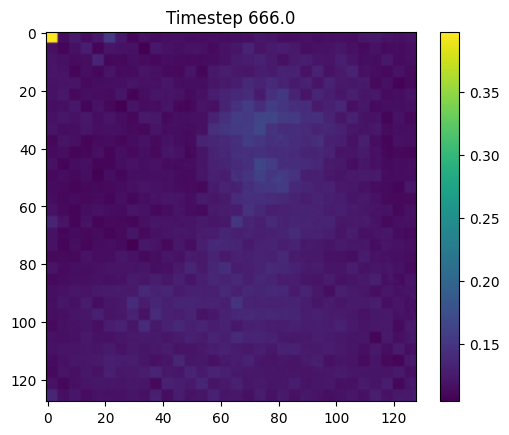

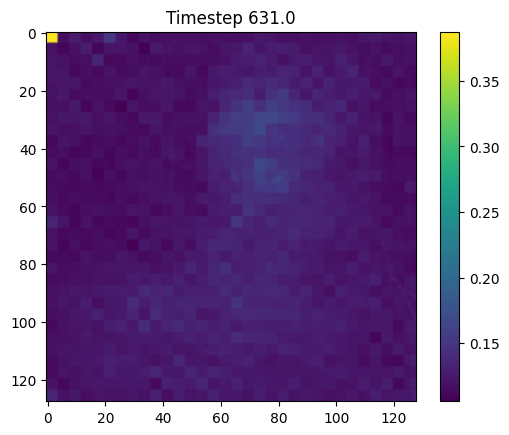

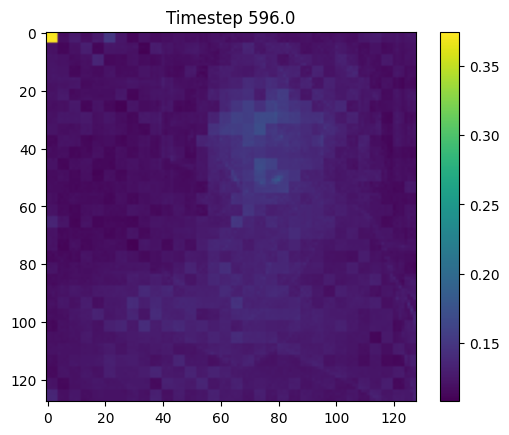

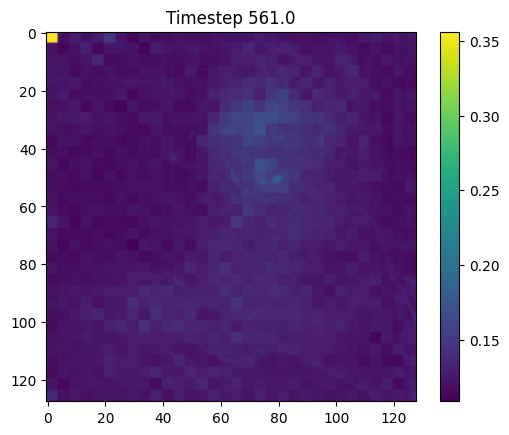

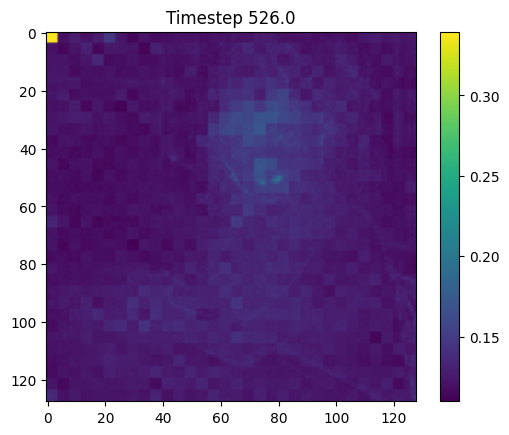

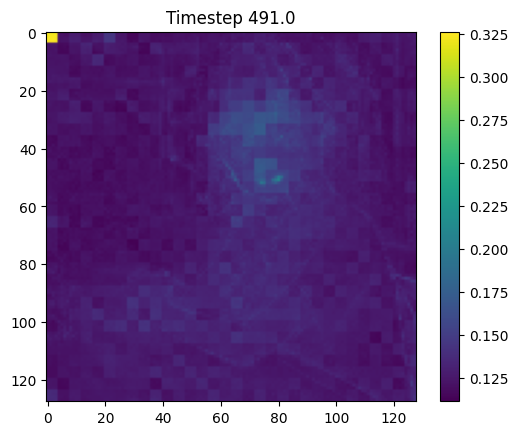

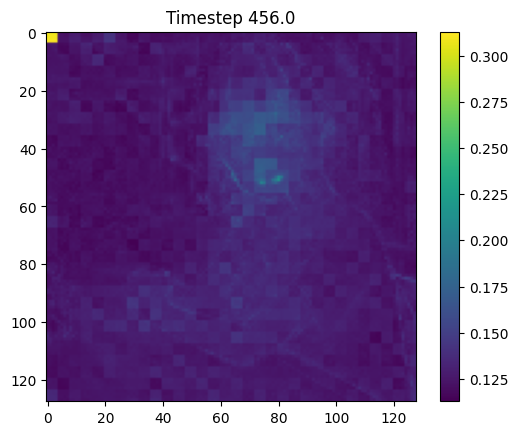

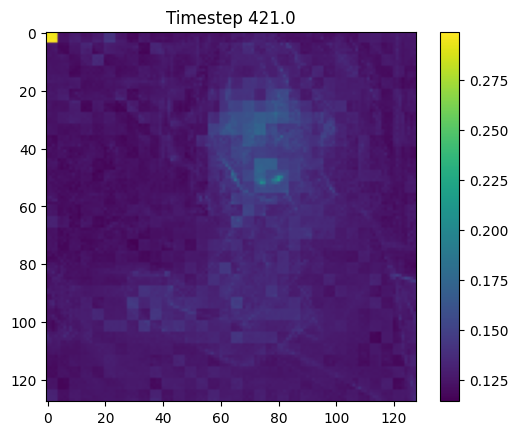

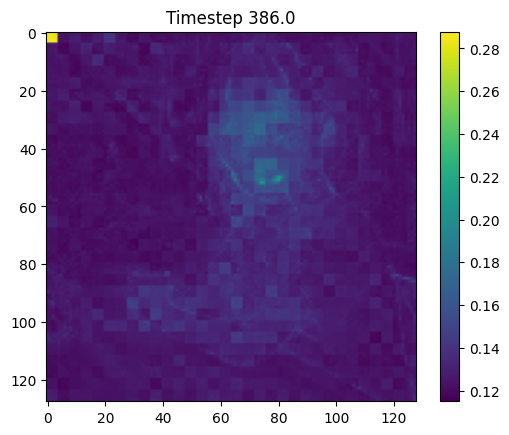

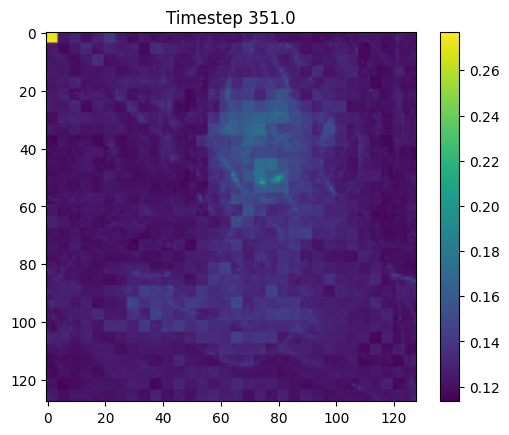

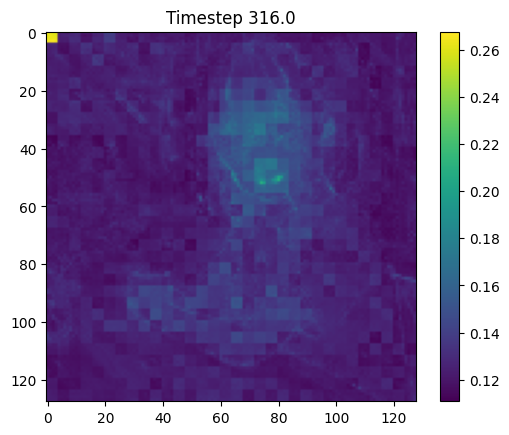

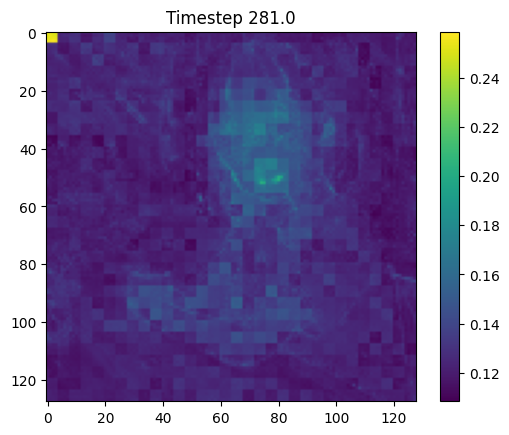

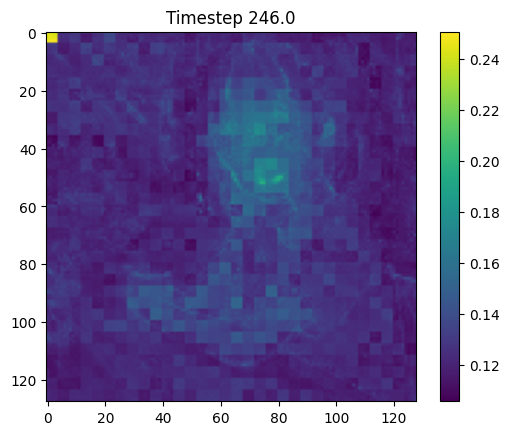

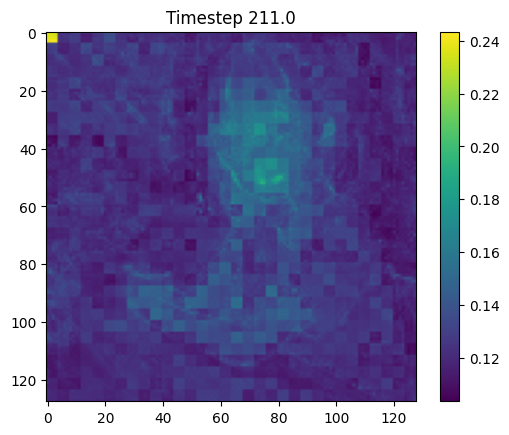

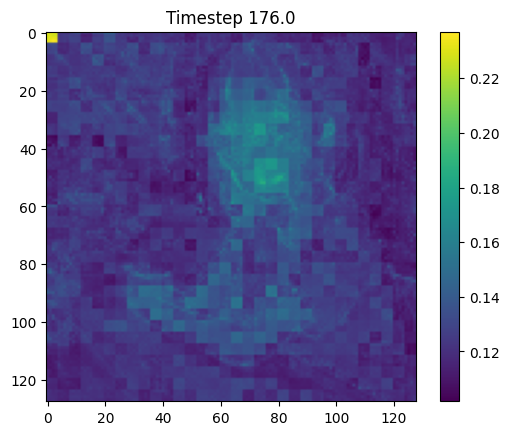

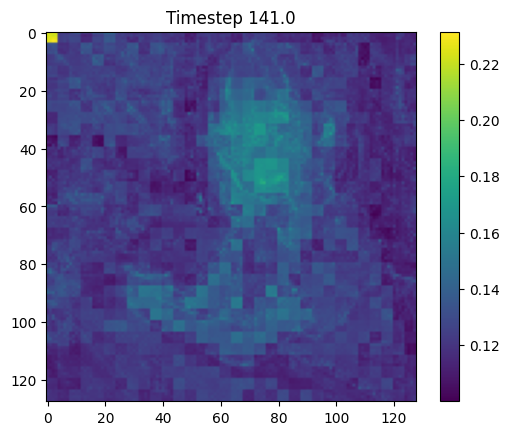

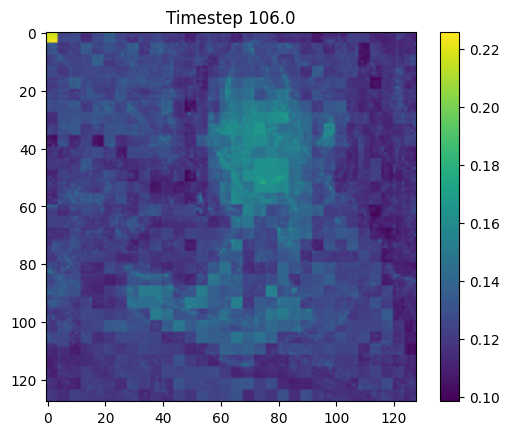

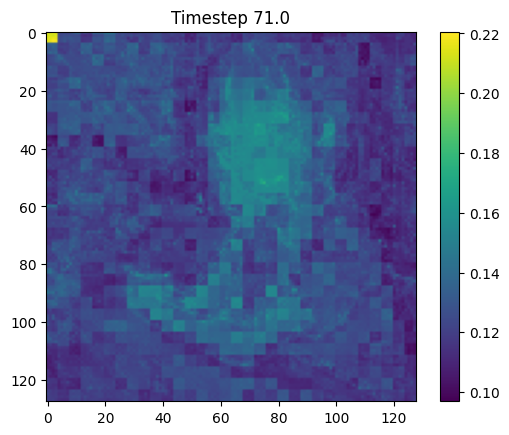

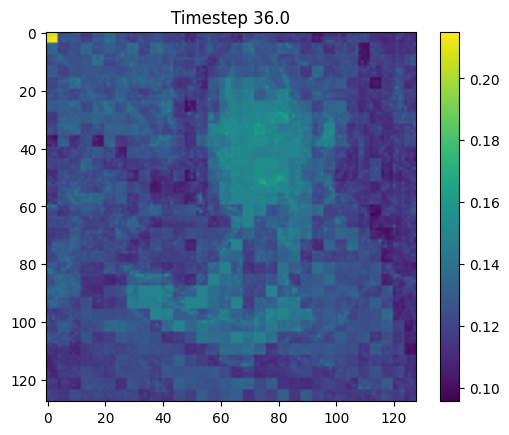

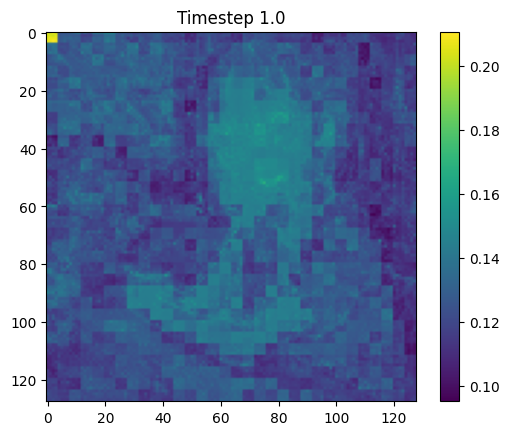

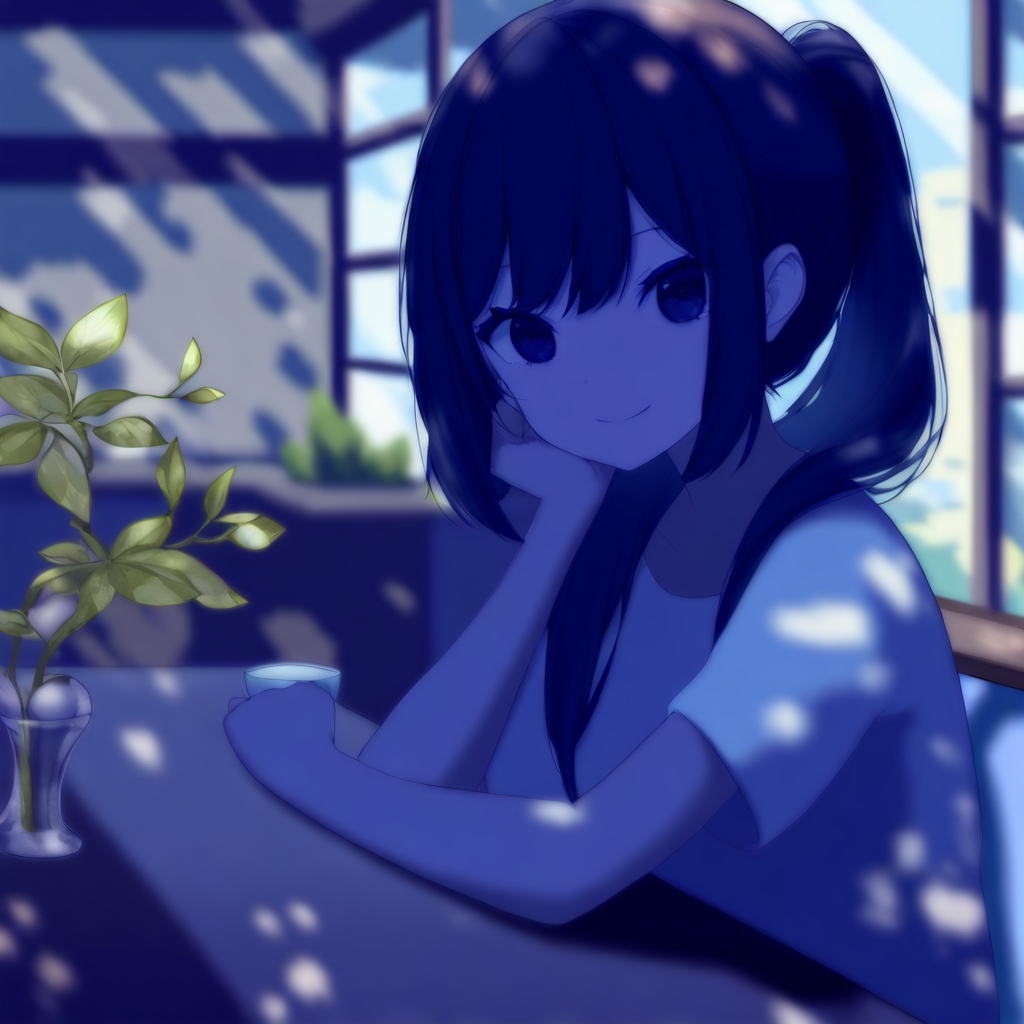

In [51]:
prompt = "1girl, hair in ponytail, looking at viewer, skin, smile, sitting at a table indoors with breakfast in front of her, masterpiece, high score, great score, absurdres"
colored_prompt = "skin"
color = [0, 0, 139]
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry"
#This is just the suggested negative prompt on the HF.
generate_colored_image(pipe, prompt, colored_prompt, color, negative_prompt, color_var=20, use_alt_saliency=True, saliency_cutoff=.12, max_timestep=700, min_timestep=0)